In [ ]:
import json
def get_metrics(path):
    with open(path, 'r') as f:
        data = json.load(f)

    train_loss = data['train_loss']
    train_acc = data['train_acc']
    test_loss = data['test_loss']
    test_acc = data['test_acc']
    return train_loss, train_acc, test_loss, test_acc
    

In [ ]:
def populate_dict(path):
    d = {}
    metrics = get_metrics(path)
    for key, value in zip(['train_loss', 'train_acc', 'test_loss','test_acc'], metrics):
        d[key] = value
    return d

In [ ]:
from rich import print as pprint
metrics_dict = {}
distillations = ['featuremap', 'tucker', 'tucker_recomp']
ranks_list = ['BATCH_SIZE,32,8,8', 'BATCH_SIZE,24,8,8', 'BATCH_SIZE,16,8,8', 'BATCH_SIZE,8,8,8']
recomp_target_list = ['teacher', 'student', 'both']
for distillation in distillations:
    metrics_dict[distillation] = {}

for rank in ranks_list:
    metrics_dict['tucker'][rank] = {}

for target in recomp_target_list:
    metrics_dict['tucker_recomp'][target] = {}
    for rank in ranks_list:
        metrics_dict['tucker_recomp'][target][rank] = {}


In [ ]:
from pathlib import Path
runs = 3 
            
distillation = 'featuremap'

for run in range(runs):
    en = f'{distillation}/{run}'
    experiment_path = Path(f'experiments/{en}')

    metrics_dict[distillation][run] = populate_dict(experiment_path) 


ranks_list = ['BATCH_SIZE,32,8,8', 'BATCH_SIZE,24,8,8', 'BATCH_SIZE,16,8,8', 'BATCH_SIZE,8,8,8']

distillation = 'tucker'
for rank in ranks_list:
    for run in range(runs):
        en = f'{distillation}/{rank}/{run}'
        experiment_path = Path(f'experiments/{en}')

        metrics_dict[distillation][rank][run] = populate_dict(experiment_path)

recomp_target_list = ['teacher', 'student', 'both']

distillation = 'tucker_recomp'
for target in recomp_target_list:
    for rank in ranks_list:
        for run in range(runs):
            en = f'{distillation}/{target}/{rank}/{run}'
            experiment_path = Path(f'experiments/{en}')

            metrics_dict[distillation][target][rank][run] = populate_dict(experiment_path)

In [ ]:
metrics_processed = {}
for distillation in distillations:
    metrics_processed[distillation] = {}

for rank in ranks_list:
    metrics_processed['tucker'][rank] = {}

for target in recomp_target_list:
    metrics_processed['tucker_recomp'][target] = {}
    for rank in ranks_list:
        metrics_processed['tucker_recomp'][target][rank] = {}

In [ ]:
import numpy as np

def stack_arrays(d):
    arrays = []
    for run in range(runs):
        arrays.append(d[run])
    stacked = np.stack([np.array(x) for x in arrays])
    mean_array = np.mean(stacked, axis=0)
    std_array = np.std(stacked, axis=0, ddof=1)
    return mean_array, std_array
    
for metric in ['train_loss', 'train_acc', 'test_loss','test_acc']:
    distillation = 'featuremap'
    mean_array, std_array = stack_arrays(metrics_dict[distillation])
    metrics_processed[distillation][metric]['mean'] = mean_array
    metrics_processed[distillation][metric]['std'] = std_array 

    distillation = 'tucker'
    for rank in ranks_list:
        mean_array, std_array = stack_arrays(metrics_dict[distillation][rank])
        metrics_processed[distillation][rank][metric]['mean'] = mean_array
        metrics_processed[distillation][rank][metric]['std'] = std_array 

    distillation = 'tucker_recomp'
    for target in recomp_target_list:
        for rank in ranks_list:
            mean_array, std_array = stack_arrays(metrics_dict[distillation][target][rank])
            metrics_processed[distillation][target][rank][metric]['mean'] = mean_array
            metrics_processed[distillation][target][rank][metric]['std'] = std_array








# EXPERIMENT

In [ ]:
import json
from pathlib import Path
from itertools import cycle

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

RUNS = 3
DISTILLATIONS = ['featuremap', 'tucker', 'tucker_recomp']
RANKS_LIST = ['BATCH_SIZE,32,8,8', 'BATCH_SIZE,24,8,8', 'BATCH_SIZE,16,8,8', 'BATCH_SIZE,8,8,8']
METRICS = ['test_acc', 'train_acc', 'test_loss', 'train_loss']

metrics_dict = {dist: {} for dist in DISTILLATIONS[:2]}
metrics_dict['tucker'] = {rank: {} for rank in RANKS_LIST}
metrics_processed = {dist: {} for dist in DISTILLATIONS[:2]}
metrics_processed['tucker'] = {rank: {} for rank in RANKS_LIST}

def get_metrics(path):
    with open(path, 'r') as f:
        data = json.load(f)
    return tuple(data[metric] for metric in METRICS)

def populate_dict(path):
    return dict(zip(METRICS, get_metrics(path)))

def print_dict_structure(d, indent=0):
    spacing = "    " * indent
    for key, value in d.items():
        print(f"{spacing}├── {key}")
        if isinstance(value, dict):
            print_dict_structure(value, indent + 1)

def stack_arrays(d, metric):
    if metric in ['test_loss', 'train_loss']:
        arrays = [np.log10(np.array(d[run][metric])) for run in range(RUNS)]
    else: 
        arrays = [np.array(d[run][metric]) for run in range(RUNS)]
    stacked = np.stack(arrays)
    return np.mean(stacked, axis=0), np.std(stacked, axis=0, ddof=1)

for run in range(RUNS):
    path = Path(f'experiments/featuremap/{run}/metrics.json')
    metrics_dict['featuremap'][run] = populate_dict(path)

for rank in RANKS_LIST:
    for run in range(RUNS):
        path = Path(f'experiments/tucker/{rank}/{run}/metrics.json')
        metrics_dict['tucker'][rank][run] = populate_dict(path)

metrics_processed['featuremap']['name'] = 'featuremap'
for metric in METRICS:
    mean, std = stack_arrays(metrics_dict['featuremap'], metric)
    metrics_processed['featuremap'][metric] = {'mean': mean, 'std': std}

for rank in RANKS_LIST:
    rank_name = f'x{int(rank.split(',')[1]) / 64}'
    metrics_processed['tucker'][rank]['name'] = f'tucker{rank_name}'
    for metric in METRICS:
        mean, std = stack_arrays(metrics_dict['tucker'][rank], metric)
        metrics_processed['tucker'][rank][metric] = {'mean': mean, 'std': std}

def collect_named_subdicts(d, results=None):
    if results is None:
        results = []

    if isinstance(d, dict):
        if "name" in d:
            results.append(d)
        for value in d.values():
            collect_named_subdicts(value, results)
    
    return results

distillation_list =  collect_named_subdicts(metrics_processed)

In [ ]:
def plt_big(size):
    if size:
        plt.rcParams.update({
            'font.size': 20,
            'axes.titlesize': 26,
            'axes.labelsize': 24,
            'xtick.labelsize': 18,
            'ytick.labelsize': 18,
            'legend.fontsize': 20,
            'figure.titlesize': 26
        })
    else:
        mpl.rcParams.update(mpl.rcParamsDefault)

    return plt.subplots(figsize=(25, 25), dpi=300) if size else plt.subplots()

def plot_things(d_list, size):
    x = np.arange(150)

    def plot_metric(metric_key, ylabel, title, ylim=None, yticks=None):
        fig, ax = plt_big(size)
        fig.patch.set_facecolor('#dbdbdb')
        ax.set_facecolor('#dbdbdb')    
        local_color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

        for d in d_list:
            color = next(local_color_cycle)
            train_data = d[f'train_{metric_key}']
            test_data = d[f'test_{metric_key}']

            for data, linestyle, label in zip([train_data, test_data], ['dotted', 'solid'], ['Train', 'Test']):
                plt.plot(x, data['mean'], 
                         linestyle=linestyle,
                         label=d['name'] if label == 'Test' else None,
                         color=color)
                plt.fill_between(x,
                                 data['mean'] - data['std'],
                                 data['mean'] + data['std'],
                                 color=color, 
                                 alpha=0.2,
                                 edgecolor=color)

        plt.xlabel('Epoch')
        plt.xlim(0, 150)
        plt.ylabel(ylabel)
        if ylim:
            plt.ylim(*ylim)
        if yticks is not None:
            plt.yticks(yticks)
        plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
        plt.title(title)
        plt.legend()
        plt.tight_layout()
        plt.show()
        plt.close()

    plot_metric('acc', 'Score', 'Accuracy', ylim=(0, 100), yticks=np.arange(0, 105, 5))
    plot_metric('loss', 'Log10 Loss', 'Loss')

def table_things():
    data = []
    for distillation in distillation_list:
        row = {'Name': distillation['name']}
        for metric in METRICS:
            row[metric] = round(distillation[metric]['mean'][-1], 2 if 'acc' in metric else 3) 
        data.append(row)
    print(pd.DataFrame(data))

In [260]:
table_things()

           Name  test_acc  train_acc  test_loss  train_loss
0    featuremap     70.07      98.04      0.162      -0.235
1    tuckerx0.5     68.54      97.35      0.174       0.271
2  tuckerx0.375     68.36      97.04      0.177       0.345
3   tuckerx0.25     67.87      95.82      0.185       0.452
4  tuckerx0.125     63.91      90.10      0.197       0.632


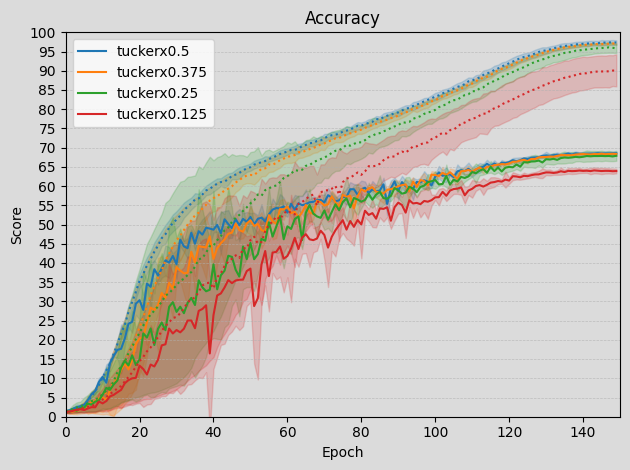

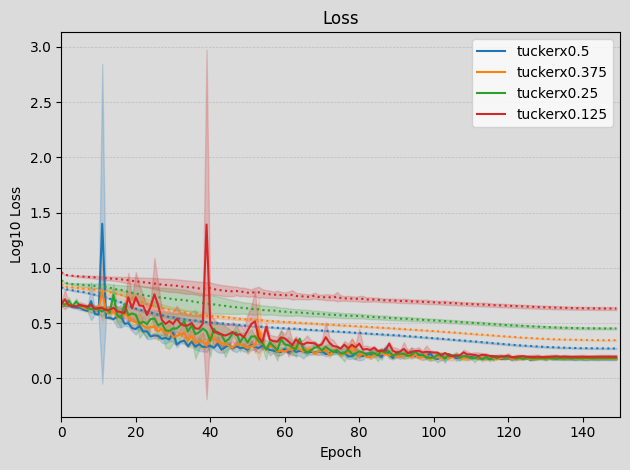

In [259]:
plot_things([d for d in distillation_list if 'tucker' in d['name']], 0)

# MAYBE TODO: compare die featuremaps wat die verskillende models produce